In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, IBMQ, execute, Aer, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

In [2]:
qrc = QuantumRegister(4, 'q')
qcc = QuantumCircuit(qrc)

qrci = QuantumRegister(4, 'q')
qcci = QuantumCircuit(qrci)

qrs = QuantumRegister(3, 'q')
qcs = QuantumCircuit(qrs)

qrsi = QuantumRegister(3, 'q')
qcsi = QuantumCircuit(qrsi)

qcc.ccx(qrc[1], qrc[2], qrc[3])
qcc.cx (qrc[1], qrc[2])
qcc.ccx(qrc[0], qrc[2], qrc[3])

CB = qcc.to_instruction()

qcs.cx (qrs[0], qrs[2])
qcs.cx (qrs[1], qrs[2])

SB = qcs.to_instruction()

qcci.ccx(qrci[0], qrci[2], qrci[3])
qcci.cx (qrci[1], qrci[2])
qcci.ccx(qrci[1], qrci[2], qrci[3])

CIB = qcci.to_instruction()

qcsi.cx (qrs[1], qrs[2])
qcsi.cx (qrs[0], qrs[2])
SIB = qcsi.to_instruction()


In [3]:
def create_adder_circuit(n):
    

    qra = QuantumRegister( (n * 3) + 1, 'q')
    qca = QuantumCircuit(qra)
    for i in range(n):
        qca.append(CB, [qra[i * 3], qra[(i * 3) + 1], qra[(i * 3) + 2], qra[(i * 3) + 3]])
    qca.cx(qra[(n*3) - 2], qra[(n*3) - 1])
    qca.append(SB, [qra[(n - 1) * 3], qra[((n - 1) * 3) + 1], qra[((n - 1) * 3) + 2]])
    for i in range(n - 2, -1, -1):
        qca.append(CIB, [qra[(i * 3)], qra[(i * 3) + 1], qra[(i * 3) + 2], qra[(i * 3) + 3]])
        qca.append(SB, [qra[(i * 3)], qra[(i * 3) + 1], qra[(i * 3) + 2]])
    return qca
adder_circuit = create_adder_circuit(4)

In [4]:
def create_sub_circuit(n):
    qra = QuantumRegister( (n * 3) + 1, 'q')
    qca = QuantumCircuit(qra)
    for i in range(n-1):
        qca.append(SIB, [qra[(i * 3)], qra[(i * 3) + 1], qra[(i * 3) + 2]])
        qca.append(CB, [qra[(i * 3)], qra[(i * 3) + 1], qra[(i * 3) + 2], qra[(i * 3) + 3]])
    qca.append(SIB, [qra[(n - 1) * 3], qra[((n - 1) * 3) + 1], qra[((n - 1) * 3) + 2]])
    qca.cx(qra[(n*3) - 2], qra[(n*3) - 1])
    for i in range(n - 1, -1, -1):
        qca.append(CIB, [qra[i * 3], qra[(i * 3) + 1], qra[(i * 3) + 2], qra[(i * 3) + 3]])
    return qca
sub_circuit = create_sub_circuit(4)

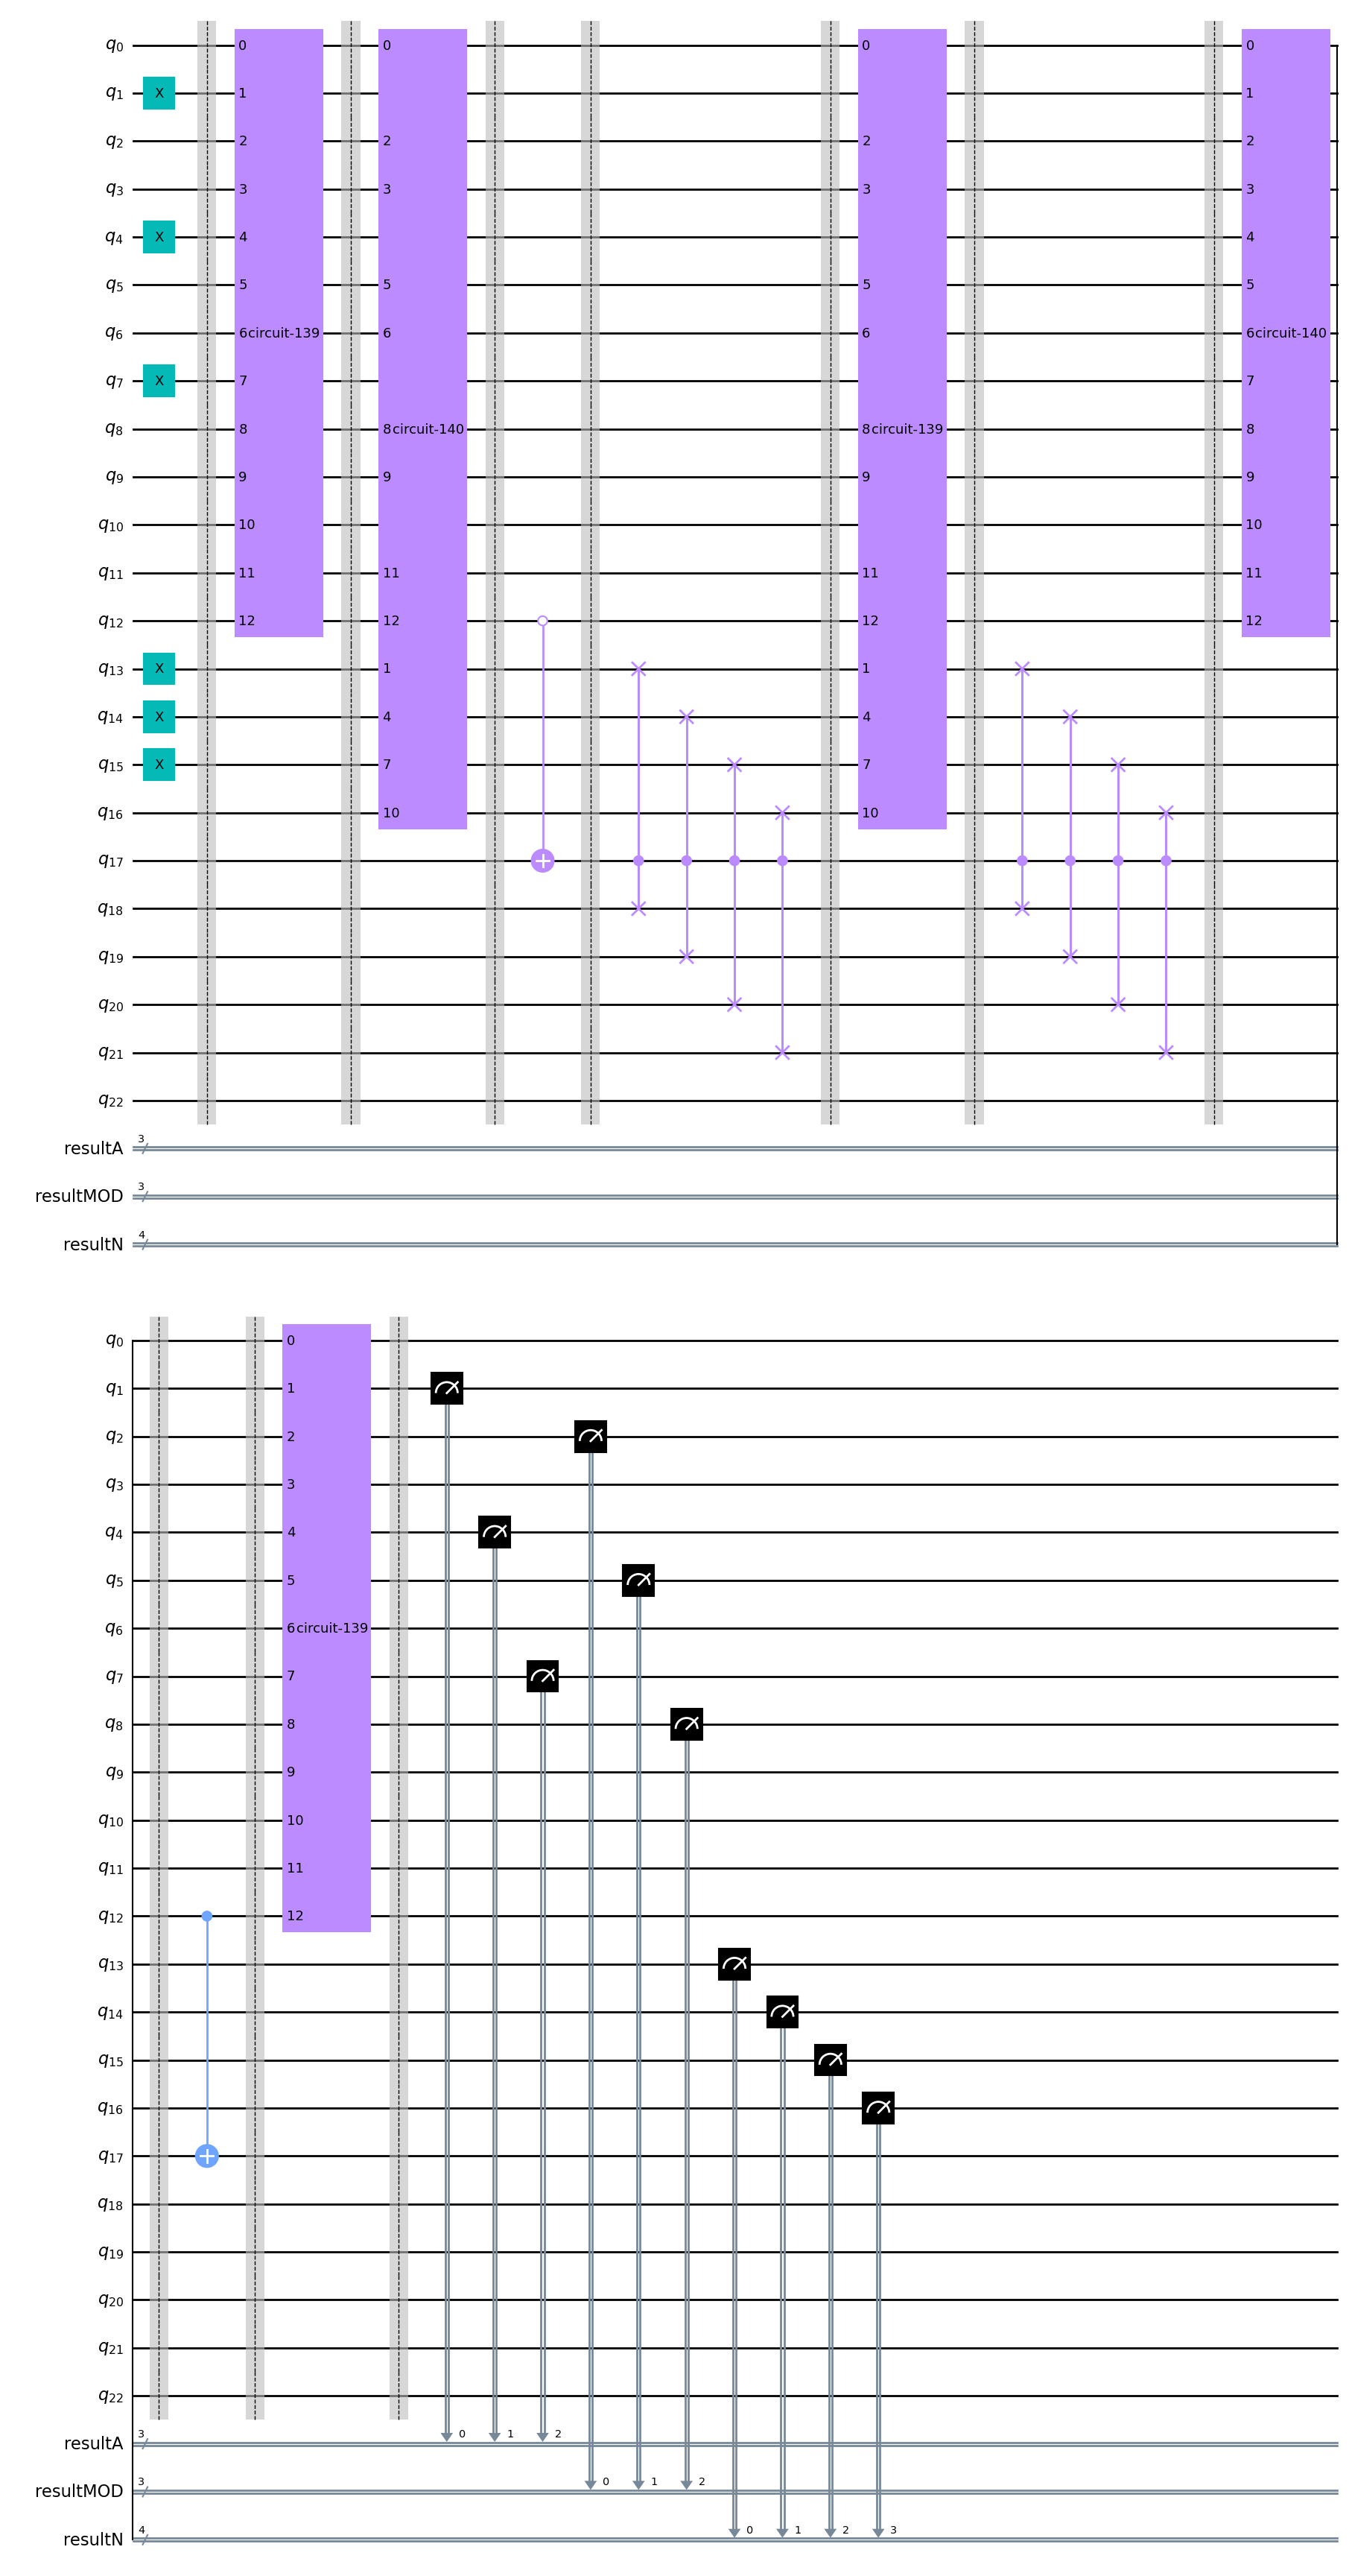

In [14]:
adder=adder_circuit.to_instruction()
sub=sub_circuit.to_instruction()

modr = QuantumRegister(23, 'q')
modc = QuantumCircuit(modr)

#a value
modc.x(1)
modc.x(4)
modc.x(7)
#N value
modc.x(13)
modc.x(14)
modc.x(15)
#modc.x(16)
modc.barrier()

modc.append(adder, [modr[i] for i in range((4*3)+1)])
modc.barrier()

modc.append(sub, [modr[0],modr[13],modr[2],modr[3],modr[14],modr[5],modr[6],modr[15],modr[8],modr[9],modr[16],modr[11],modr[12]])
modc.barrier()

modc.cx(12, 17, ctrl_state='0')
modc.barrier()

modc.cswap(17,18,13)
modc.cswap(17,19,14)
modc.cswap(17,20,15)
modc.cswap(17,21,16)
modc.barrier()

modc.append(adder, [modr[0],modr[13],modr[2],modr[3],modr[14],modr[5],modr[6],modr[15],modr[8],modr[9],modr[16],modr[11],modr[12]])
modc.barrier()

modc.cswap(17,18,13)
modc.cswap(17,19,14)
modc.cswap(17,20,15)
modc.cswap(17,21,16)
modc.barrier()

modc.append(sub, [modr[i] for i in range((4*3)+1)])
modc.barrier()

modc.cx(12, 17, ctrl_state='1')
modc.barrier()

modc.append(adder, [modr[i] for i in range((4*3)+1)])
modc.barrier()

# Define classical register for measurement
resultA = ClassicalRegister(3, 'resultA')
resultMOD = ClassicalRegister(3, 'resultMOD')
resultN = ClassicalRegister(4, 'resultN')

# Add the classical register to the quantum circuit
modc.add_register(resultA)
modc.add_register(resultMOD)
modc.add_register(resultN)

# Measure the SUM output qubits
modc.measure(modr[1], resultA[0])
modc.measure(modr[4], resultA[1])
modc.measure(modr[7], resultA[2])

modc.measure(modr[2], resultMOD[0])
modc.measure(modr[5], resultMOD[1])
modc.measure(modr[8], resultMOD[2])

modc.measure(modr[13], resultN[0])
modc.measure(modr[14], resultN[1])
modc.measure(modr[15], resultN[2])
modc.measure(modr[16], resultN[3])

modc.draw()


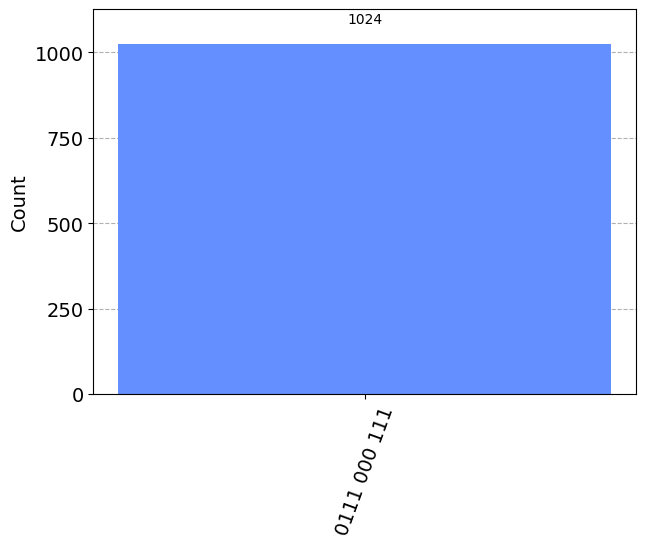

In [15]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(modc, simulator, shots=1024)
result = job.result()
counts = result.get_counts(modc)
plot_histogram(counts)